# GenHack 2025 - Week 1: Data Loading and Exploration
## 1. Introduction

### 1.1 Challenge Context
GenHack 2025 focuses on analyzing the Urban Heat Island (UHI) effect using multiple data sources:
- **ERA5-Land**: Rescaled temperature reanalysis data
- **Ground Weather Stations**: Ground truth temperature measurements  
- **Sentinel-2 NDVI**: Vegetation density maps as proxy for urbanization

### 1.2 Week 1 Objectives
- Explore and understand all three data sources
- Establish initial data integration pipeline
- Identify preliminary relationships between vegetation and temperature accuracy
- Select representative stations for detailed analysis


## Requirements

In [2]:
!pip install numpy pandas xarray rasterio geopandas matplotlib netCDF4


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
from rasterio.warp import transform
from rasterio.plot import show
import seaborn as sns
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
warnings.filterwarnings('ignore')


## Configure Environment

In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = "/Users/mellissahafis/Documents/GenHack2025/data"  # Change to your data directory path
STUDY_AREA = "France"  # Change to your chosen study area
STUDY_BBOX = [-5, 42, 10, 52]  # [lon_min, lat_min, lon_max, lat_max] for France

## 2. Data Overview

### 2.1 Weather Stations (Ground Truth)
- **Total stations available**: 8,568 across Europe
- **French stations**: 863 within study area bbox [-5, 42, 10, 52]
- **Data period**: 2020-2023 (4 years of daily maximum temperatures)
- **Sample station**: MARSEILLE OBS. PALAIS-LONCHAMP (43.305°N, 5.397°E)

### 2.2 ERA5-Land Data (Reanalysis)
- **Spatial coverage**: Europe (lon: -25.0 to 40.9°, lat: 35.0 to 69.9°)
- **Resolution**: ~9km grid (350×660 pixels)
- **Temporal coverage**: 2020-2023 (1,461 days)
- **Temperature range**: -34.8°C to 49.0°C (after conversion from Kelvin)
- **Seasonal means**: Winter 2.4°C, Spring 10.9°C, Summer 23.0°C, Fall 12.6°C

### 2.3 Sentinel-2 NDVI Data
**⚠️ Data Limitation Note**: Due to computational constraints, this analysis used only 1 of 19 available NDVI files (`ndvi_2022-03-01_2022-06-01.tif`). Future analyses will incorporate the full dataset.

- **Single file used**: Spring 2022 (March 1 - June 1)
- **Spatial resolution**: 80m × 80m
- **Coverage**: Pan-European (5,2389×61,776 pixels)
- **NDVI range**: -1.000 to 0.992
- **Distribution**:
  - Very low (<0.0): 29.0% (water/urban)
  - Low (0.0-0.2): 11.4% (sparse vegetation/urban)
  - Medium (0.2-0.5): 30.3% (grassland/crops)
  - High (0.5-0.8): 27.9% (dense vegetation)
  - Very high (>0.8): 1.3% (forests)

## 3. Methodology

### 3.1 Station Selection Strategy
We selected 5 French stations representing an urban-rural gradient based on NDVI values from the single available file:

| Station ID | Station Name | Latitude | Longitude | Height (m) | NDVI | Category |
|------------|--------------|----------|-----------|------------|------|----------|
| 755 | EMBRUN | 44.566°N | 6.502°E | 871 | 0.283 | Suburban |
| 11243 | TROYES-BARBEREY | 48.324°N | 4.020°E | 112 | 0.441 | Rural |
| 11246 | NANCY-OCHEY | 48.581°N | 5.959°E | 336 | 0.512 | Rural |
| 2205 | ST-GIRONS | 43.005°N | 1.107°E | 414 | 0.638 | Rural |
| 738 | CAEN-CARPIQUET | 49.180°N | -0.456°E | 67 | 0.685 | Rural |

### 3.2 Data Integration
- Extracted ERA5 temperature values at each station's nearest grid point
- Calculated NDVI values at each station location from the single Sentinel-2 file
- Aligned all datasets temporally (2020-2023) and spatially

### 3.3 Error Metrics
- **Bias**: Mean(ERA5 - Observed)
- **RMSE**: Root Mean Square Error
- **MAE**: Mean Absolute Error
- **Correlation**: Pearson correlation coefficient

#### 1. First data loading and exploration (overview sample files)

In [5]:
# ============================================================================
# 1. LOAD WEATHER STATION DATA (Ground Truth)
# ============================================================================

def extract_eca_data(zip_path):
    """Extract ECA weather station data if not already extracted"""
    extract_dir = os.path.join(DATA_DIR, "ECA_blend_tx")
    if not os.path.exists(extract_dir):
        print("Extracting ECA weather station data...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✓ Extracted to {extract_dir}")
    return extract_dir

def dms_to_decimal(dms_str):
    """Convert degrees:minutes:seconds to decimal degrees"""
    try:
        # Remove whitespace
        dms_str = str(dms_str).strip()
        
        # Check if already a number
        try:
            return float(dms_str)
        except:
            pass
        
        # Parse DMS format: +56:52:00 or -003:30:00
        if ':' not in dms_str:
            return np.nan
        
        # Determine sign
        sign = 1 if dms_str[0] == '+' else -1
        
        # Remove sign and split
        parts = dms_str[1:].split(':')
        
        if len(parts) != 3:
            return np.nan
        
        degrees = float(parts[0])
        minutes = float(parts[1])
        seconds = float(parts[2])
        
        decimal = sign * (degrees + minutes/60 + seconds/3600)
        return decimal
    except:
        return np.nan

def load_eca_stations(eca_dir):
    """Load weather station metadata"""
    stations_file = os.path.join(eca_dir, "stations.txt")
    
    # Read station metadata, skipping header lines
    # Header ends at line with "STAID,STANAME..."
    stations = pd.read_csv(
        stations_file,
        skiprows=17,  # Skip the header description
        sep=',',
        skipinitialspace=True,
        names=['STAID', 'STANAME', 'CN', 'LAT', 'LON', 'HGHT']
    )
    
    # Clean column data
    stations['STAID'] = pd.to_numeric(stations['STAID'], errors='coerce')
    stations['STANAME'] = stations['STANAME'].str.strip()
    stations['CN'] = stations['CN'].str.strip()
    
    # Convert DMS coordinates to decimal degrees
    print("Converting coordinates from DMS to decimal degrees...")
    stations['LAT_DECIMAL'] = stations['LAT'].apply(dms_to_decimal)
    stations['LON_DECIMAL'] = stations['LON'].apply(dms_to_decimal)
    stations['HGHT'] = pd.to_numeric(stations['HGHT'], errors='coerce')
    
    # Remove rows with invalid data
    stations = stations.dropna(subset=['STAID', 'LAT_DECIMAL', 'LON_DECIMAL'])
    
    print(f"\n{'='*60}")
    print("WEATHER STATIONS (Ground Truth)")
    print(f"{'='*60}")
    print(f"Total stations: {len(stations)}")
    print(f"\nFirst few stations:")
    print(stations[['STAID', 'STANAME', 'CN', 'LAT_DECIMAL', 'LON_DECIMAL', 'HGHT']].head(10))
    
    print(f"\nStation countries (top 10):")
    print(stations['CN'].value_counts().head(10))
    
    # Filter to study area using decimal coordinates
    stations_filtered = stations[
        (stations['LON_DECIMAL'] >= STUDY_BBOX[0]) & 
        (stations['LON_DECIMAL'] <= STUDY_BBOX[2]) &
        (stations['LAT_DECIMAL'] >= STUDY_BBOX[1]) & 
        (stations['LAT_DECIMAL'] <= STUDY_BBOX[3])
    ].copy()
    
    print(f"\nStations in study area ({STUDY_AREA}, bbox {STUDY_BBOX}):")
    print(f"Total: {len(stations_filtered)}")
    
    if len(stations_filtered) > 0:
        print(f"\nSample stations in {STUDY_AREA}:")
        print(stations_filtered[['STAID', 'STANAME', 'CN', 'LAT_DECIMAL', 'LON_DECIMAL', 'HGHT']].head(10))
    
    return stations, stations_filtered

def load_eca_temperature_sample(eca_dir, station_id=None):
    """Load temperature data for a sample station"""
    # Find temperature data files
    data_files = [f for f in os.listdir(eca_dir) if f.startswith('TX_') and f.endswith('.txt')]
    
    if not data_files:
        print("Warning: No temperature data files found")
        return None
    
    sample_file = os.path.join(eca_dir, data_files[0])
    print(f"\nLoading sample temperature data from: {data_files[0]}")
    
    # Read temperature data
    temp_data = pd.read_csv(
        sample_file,
        skiprows=20,  # Adjust based on actual file
        sep=',',
        names=['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX']
    )
    
    # Convert date and temperature
    temp_data['DATE'] = pd.to_datetime(temp_data['DATE'].astype(str), format='%Y%m%d', errors='coerce')
    temp_data['TX'] = pd.to_numeric(temp_data['TX'], errors='coerce')
    temp_data['TX_C'] = temp_data['TX'] / 10.0  # Convert to Celsius
    
    # Filter to recent years (2020-2023)
    temp_data = temp_data[temp_data['DATE'] >= '2020-01-01']
    
    print(f"Temperature records: {len(temp_data)}")
    print(f"Date range: {temp_data['DATE'].min()} to {temp_data['DATE'].max()}")
    print(f"Temperature range: {temp_data['TX_C'].min():.1f}°C to {temp_data['TX_C'].max():.1f}°C")
    print(f"\nSample data:")
    print(temp_data.head())
    
    return temp_data

In [6]:
# ============================================================================
# 2. LOAD ERA5-LAND DATA (Reanalysis)
# ============================================================================

import os
import zipfile
import tempfile
import xarray as xr
import pandas as pd

def extract_era5_data(zip_path):
    """Extract ERA5 data if not already extracted"""
    extract_dir = os.path.join(DATA_DIR, "derived-era5-land-daily-statistics")
    if not os.path.exists(extract_dir):
        print("Extracting ERA5-Land data...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✓ Extracted to {extract_dir}")
    else:
        print(f"ERA5 data already extracted at {extract_dir}")
    return extract_dir


def load_era5_sample(era5_dir):
    """Load a sample ERA5-Land NetCDF file"""
    # Find temperature NetCDF files specifically
    nc_files = []
    for root, dirs, files in os.walk(era5_dir):
        for file in files:
            if 'temperature' in file.lower() and file.endswith('.nc'):
                nc_files.append(os.path.join(root, file))
    
    if not nc_files:
        print("Warning: No temperature NetCDF files found in ERA5 directory")
        return None
    
    print(f"\n{'='*60}")
    print("ERA5-LAND DATA (Reanalysis)")
    print(f"{'='*60}")
    print(f"Found {len(nc_files)} temperature NetCDF files")
    print(f"Files: {[os.path.basename(f) for f in nc_files]}")
    
    # Load first file as sample
    sample_file = nc_files[0]
    print(f"\nLoading sample file: {os.path.basename(sample_file)}")
    
    ds = xr.open_dataset(sample_file)
    
    print(f"\nDataset structure:")
    print(ds)
    
    print(f"\nVariables: {list(ds.data_vars)}")
    print(f"Coordinates: {list(ds.coords)}")
    
    # Check for different possible coordinate names
    lon_coord = None
    lat_coord = None
    time_coord = None
    
    for coord in ['longitude', 'lon', 'x']:
        if coord in ds.coords:
            lon_coord = coord
            break
    
    for coord in ['latitude', 'lat', 'y']:
        if coord in ds.coords:
            lat_coord = coord
            break
    
    for coord in ['time', 'date', 'datetime']:
        if coord in ds.coords:
            time_coord = coord
            break
    
    if lon_coord and lat_coord:
        print(f"\nSpatial extent: lon [{ds[lon_coord].min().values:.2f}, {ds[lon_coord].max().values:.2f}], "
              f"lat [{ds[lat_coord].min().values:.2f}, {ds[lat_coord].max().values:.2f}]")
    
    if time_coord:
        print(f"Time range: {pd.to_datetime(ds[time_coord].min().values)} to {pd.to_datetime(ds[time_coord].max().values)}")
    else:
        print("Note: No time coordinate found in dataset")
    
    # Get temperature variable
    temp_vars = list(ds.data_vars)
    if temp_vars:
        temp = ds[temp_vars[0]]
        print(f"\nTemperature variable: {temp_vars[0]}")
        print(f"Shape: {temp.shape}")
        print(f"Dimensions: {temp.dims}")
        print(f"Units: {temp.attrs.get('units', 'Unknown')}")
        
        # Show temperature statistics
        print(f"\nTemperature statistics:")
        print(f"Min: {float(temp.min().values):.2f}")
        print(f"Max: {float(temp.max().values):.2f}")
        print(f"Mean: {float(temp.mean().values):.2f}")
        
        # Convert from Kelvin to Celsius if needed
        if temp.attrs.get('units') in ['K', 'Kelvin', 'kelvin']:
            print("Note: Temperature is in Kelvin, subtract 273.15 to convert to Celsius")
    
    return ds

In [8]:
# ============================================================================
# 3. LOAD SENTINEL-2 NDVI DATA (Vegetation)
# ============================================================================


def convert_ndvi_to_real_scale(ndvi_array):
    """Convert NDVI from int8 (0-254) to real scale (-1 to 1)"""
    ndvi_real = np.where(
        ndvi_array == 255,  # nodata value
        np.nan,
        (ndvi_array / 254.0) * 2.0 - 1.0
    )
    return ndvi_real

def extract_ndvi_data(zip_path):
    """Extract NDVI data if not already extracted"""
    extract_dir = os.path.join(DATA_DIR, "sentinel2_ndvi")
    if not os.path.exists(extract_dir):
        print("Extracting Sentinel-2 NDVI data (this may take a while, ~16GB)...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✓ Extracted to {extract_dir}")
    else:
        print(f"NDVI data already extracted at {extract_dir}")
    return extract_dir

def load_ndvi_sample(ndvi_dir):
    """Load a sample NDVI GeoTIFF file"""
    # Find GeoTIFF files
    tif_files = []
    for root, dirs, files in os.walk(ndvi_dir):
        for file in files:
            if file.endswith('.tif') or file.endswith('.tiff'):
                tif_files.append(os.path.join(root, file))
    
    if not tif_files:
        print("Warning: No GeoTIFF files found in NDVI directory")
        return None, None
    
    print(f"\n{'='*60}")
    print("SENTINEL-2 NDVI DATA (Vegetation)")
    print(f"{'='*60}")
    print(f"Found {len(tif_files)} GeoTIFF files")
    
    # Load first file as sample
    sample_file = tif_files[0]
    print(f"\nLoading sample file: {os.path.basename(sample_file)}")
    
    with rasterio.open(sample_file) as src:
        ndvi_raw = src.read(1)
        ndvi_real = convert_ndvi_to_real_scale(ndvi_raw)
        
        print(f"\nRaster properties:")
        print(f"Shape: {src.shape}")
        print(f"Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"CRS: {src.crs}")
        print(f"Bounds: {src.bounds}")
        
        print(f"\nNDVI statistics (converted to -1 to 1 scale):")
        print(f"Min: {np.nanmin(ndvi_real):.3f}")
        print(f"Max: {np.nanmax(ndvi_real):.3f}")
        print(f"Mean: {np.nanmean(ndvi_real):.3f}")
        print(f"% NoData: {(np.isnan(ndvi_real).sum() / ndvi_real.size * 100):.1f}%")
        
        return src, ndvi_real

In [9]:
# ============================================================================
# 4. LOAD ADMINISTRATIVE BOUNDARIES
# ============================================================================

def load_admin_boundaries(gpkg_path):
    """Load GADM administrative boundaries"""
    print(f"\n{'='*60}")
    print("ADMINISTRATIVE BOUNDARIES")
    print(f"{'='*60}")
    
    # List layers in GeoPackage
    layers = gpd.list_layers(gpkg_path)
    print(f"Available layers: {layers['name'].tolist()}")
    
    # Load country boundaries (level 0)
    gdf = gpd.read_file(gpkg_path, layer='gadm_410_europe_light')  # Adjust layer name as needed
    
    print(f"\nCountries in dataset: {len(gdf)}")
    print(f"Columns: {gdf.columns.tolist()}")
    print(f"\nFirst few countries:")
    print(gdf[['COUNTRY', 'GID_0']].head(10))
    
    # Filter to study area if possible
    if STUDY_AREA in gdf['COUNTRY'].values:
        study_gdf = gdf[gdf['COUNTRY'] == STUDY_AREA]
        print(f"\nStudy area ({STUDY_AREA}) found!")
    else:
        print(f"\nNote: {STUDY_AREA} not found in exact match, showing available countries")
        study_gdf = gdf
    
    return gdf, study_gdf

In [10]:
# ============================================================================
# 5. VISUALIZATION
# ============================================================================
def create_overview_plot(stations_filtered, admin_gdf):
    """Create an overview map of the study area"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot administrative boundaries
    admin_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
    
    # Plot weather stations
    if stations_filtered is not None and len(stations_filtered) > 0:
        ax.scatter(stations_filtered['LON_DECIMAL'], stations_filtered['LAT_DECIMAL'], 
                  c='red', s=50, marker='^', label='Weather Stations', 
                  alpha=0.7, edgecolors='darkred')
        
        # Add station count to title
        station_count = len(stations_filtered)
        title = f'Study Area: {STUDY_AREA}\nWeather Stations ({station_count} total) and Administrative Boundaries'
    else:
        station_count = 0
        title = f'Study Area: {STUDY_AREA}\nNo Weather Stations Found in Bounding Box'
    
    ax.set_xlim(STUDY_BBOX[0], STUDY_BBOX[2])
    ax.set_ylim(STUDY_BBOX[1], STUDY_BBOX[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('week1_study_area_overview.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved overview map: week1_study_area_overview.png")
    plt.show()
    
    return station_count




GenHack 2025 - Week 1: Data Exploration
Converting coordinates from DMS to decimal degrees...

WEATHER STATIONS (Ground Truth)
Total stations: 8568

First few stations:
    STAID                STANAME  CN  LAT_DECIMAL  LON_DECIMAL   HGHT
1     1.0                VAEXJOE  SE    56.866667    14.800000  166.0
2     2.0                  FALUN  SE    60.616667    15.616667  160.0
3     3.0               STENSELE  SE    65.066667    17.166389  325.0
4     4.0             LINKOEPING  SE    58.400000    15.533056   93.0
5     5.0  LINKOEPING-MALMSLAETT  SE    58.400000    15.533056   93.0
6     6.0               KARLSTAD  SE    59.350000    13.466667   46.0
7     7.0       KARLSTAD-AIRPORT  SE    59.444444    13.337500  107.0
8     8.0             OESTERSUND  SE    63.183056    14.483056  376.0
9     9.0    OESTERSUND-FROESOEN  SE    63.183056    14.483056  376.0
10   10.0              STOCKHOLM  SE    59.350000    18.050000   44.0

Station countries (top 10):
CN
IT    1112
DE    1054
ES    1

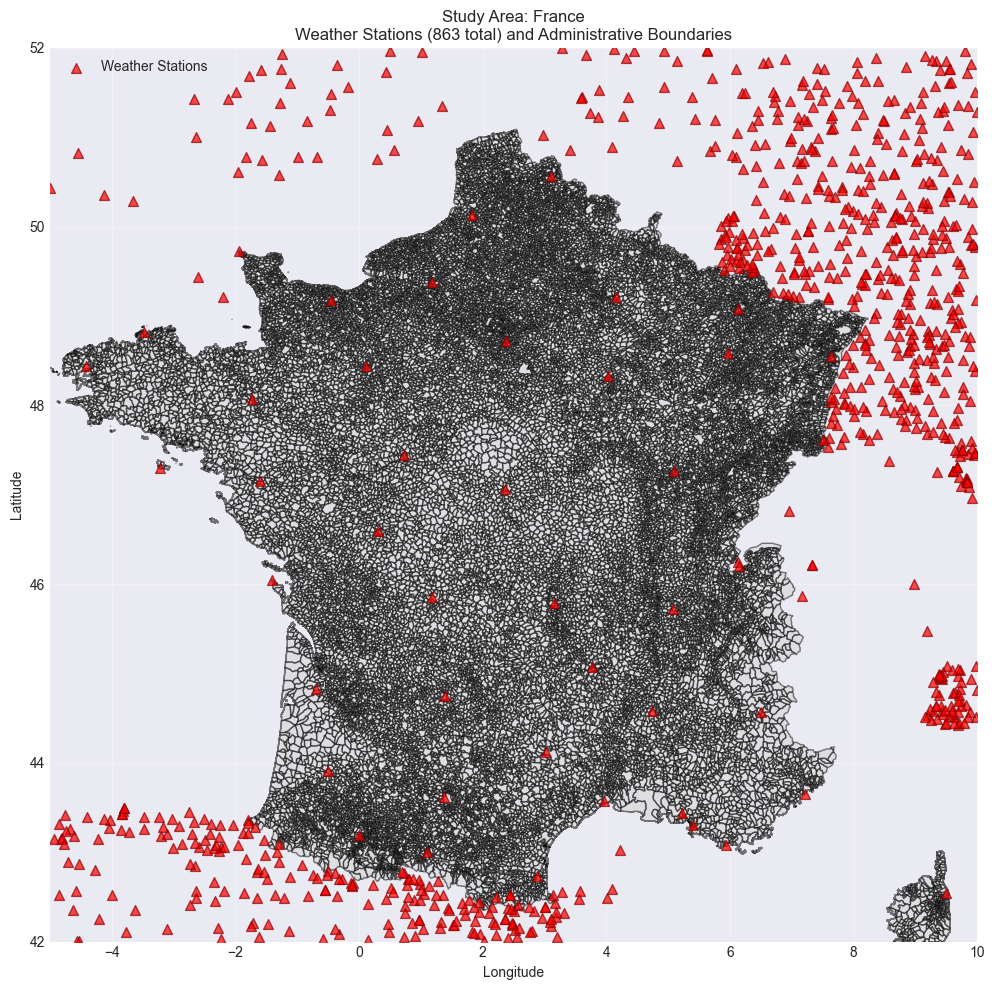


SUMMARY
✓ Weather stations loaded: 863 in study area
✓ ERA5 data: Loaded
✓ NDVI data: Loaded
✓ Admin boundaries: Loaded

Next steps for Week 1:
1. Choose 2-3 specific stations in urban/rural areas
2. Extract ERA5 temperatures at station locations
3. Compare ERA5 vs ground truth temperatures
4. Overlay NDVI to identify urban heat island zones


In [11]:
def main():
    print("="*60)
    print("GenHack 2025 - Week 1: Data Exploration")
    print("="*60)
    
    # 1. Load weather station data
    eca_zip = os.path.join(DATA_DIR, "ECA_blend_tx.zip")
    if os.path.exists(eca_zip):
        eca_dir = extract_eca_data(eca_zip)
        stations, stations_filtered = load_eca_stations(eca_dir)
        temp_sample = load_eca_temperature_sample(eca_dir)
    else:
        print(f"Warning: {eca_zip} not found")
        stations, stations_filtered, temp_sample = None, None, None
    
    # 2. Load ERA5 data
    # Check for zip file first, then extracted directory
    era5_zip = os.path.join(DATA_DIR, "derived-era5-land-daily-statistics.zip")
    era5_dir = os.path.join(DATA_DIR, "derived-era5-land-daily-statistics")
    
    # Also check for any era5 zip file with timestamp
    if not os.path.exists(era5_zip):
        possible_zips = [f for f in os.listdir(DATA_DIR) if f.startswith('derived-era5-land-daily-statistics') and f.endswith('.zip')]
        if possible_zips:
            era5_zip = os.path.join(DATA_DIR, possible_zips[0])
    
    if os.path.exists(era5_zip):
        era5_dir = extract_era5_data(era5_zip)
        era5_data = load_era5_sample(era5_dir)
    elif os.path.exists(era5_dir):
        era5_data = load_era5_sample(era5_dir)
    else:
        print(f"Warning: ERA5 data not found (looking for {era5_zip} or {era5_dir})")
        era5_data = None
    
    # 3. Load NDVI data
    # Check for zip file first, then extracted directory
    ndvi_zip = os.path.join(DATA_DIR, "sentinel2_ndvi.zip")
    ndvi_dir = os.path.join(DATA_DIR, "sentinel2_ndvi")
    
    # Also check for the actual zip file you have
    if not os.path.exists(ndvi_zip):
        # Look for any sentinel2_ndvi zip file
        possible_zips = [f for f in os.listdir(DATA_DIR) if f.startswith('sentinel2_ndvi') and f.endswith('.zip')]
        if possible_zips:
            ndvi_zip = os.path.join(DATA_DIR, possible_zips[0])
    
    if os.path.exists(ndvi_zip):
        ndvi_dir = extract_ndvi_data(ndvi_zip)
        ndvi_src, ndvi_data = load_ndvi_sample(ndvi_dir)
    elif os.path.exists(ndvi_dir):
        ndvi_src, ndvi_data = load_ndvi_sample(ndvi_dir)
    else:
        print(f"Warning: NDVI data not found (looking for {ndvi_zip} or {ndvi_dir})")
        ndvi_src, ndvi_data = None, None
    
    # 4. Load admin boundaries
    gpkg_path = os.path.join(DATA_DIR, "gadm_410_europe.gpkg")
    if os.path.exists(gpkg_path):
        admin_gdf, study_gdf = load_admin_boundaries(gpkg_path)
    else:
        print(f"Warning: {gpkg_path} not found")
        admin_gdf, study_gdf = None, None
    
    # 5. Create overview visualization
    if stations_filtered is not None and study_gdf is not None:
        create_overview_plot(stations_filtered, study_gdf)
    
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"✓ Weather stations loaded: {len(stations_filtered) if stations_filtered is not None else 0} in study area")
    print(f"✓ ERA5 data: {'Loaded' if era5_data is not None else 'Not found'}")
    print(f"✓ NDVI data: {'Loaded' if ndvi_data is not None else 'Not found'}")
    print(f"✓ Admin boundaries: {'Loaded' if admin_gdf is not None else 'Not found'}")
    print("\nNext steps for Week 1:")
    print("1. Choose 2-3 specific stations in urban/rural areas")
    print("2. Extract ERA5 temperatures at station locations")
    print("3. Compare ERA5 vs ground truth temperatures")
    print("4. Overlay NDVI to identify urban heat island zones")
    print("="*60)

if __name__ == "__main__":
    main()
    

#### 2. Comprehensive analysis

GenHack 2025 - Week 1: Comprehensive Data Analysis
Deep exploration of all datasets + 5-station detailed analysis

This script:
1. Loads and analyzes ALL ERA5 files (2020-2025)
2. Loads and analyzes ALL NDVI quarters
3. Selects 5 strategic stations across urban-rural gradient
4. Extracts complete time series for each station
5. Performs comparative analysis ERA5 vs ground truth
6. Correlates errors with NDVI

In [24]:
"""
This script:
1. Loads and analyzes ALL ERA5 files (2020-2025)
2. Loads and analyzes ALL NDVI quarters
3. Selects 5 strategic stations across urban-rural gradient
4. Extracts complete time series for each station
5. Performs comparative analysis ERA5 vs ground truth
6. Correlates errors with NDVI
"""
warnings.filterwarnings('ignore')
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = "/Users/mellissahafis/Documents/GenHack2025/data"
STUDY_AREA = "France"
STUDY_BBOX = [-5, 42, 10, 52]  # [lon_min, lat_min, lon_max, lat_max]

# Analysis period
ANALYSIS_YEARS = [2020, 2021, 2022, 2023]  # Focus on complete overlap

# Output directory
OUTPUT_DIR = "week1_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def dms_to_decimal(dms_str):
    """Convert degrees:minutes:seconds to decimal degrees"""
    try:
        dms_str = str(dms_str).strip()
        try:
            return float(dms_str)
        except:
            pass
        if ':' not in dms_str:
            return np.nan
        sign = 1 if dms_str[0] == '+' else -1
        parts = dms_str[1:].split(':')
        if len(parts) != 3:
            return np.nan
        degrees = float(parts[0])
        minutes = float(parts[1])
        seconds = float(parts[2])
        decimal = sign * (degrees + minutes/60 + seconds/3600)
        return decimal
    except:
        return np.nan

def convert_ndvi_to_real_scale(ndvi_array):
    """Convert NDVI from int8 (0-254) to real scale (-1 to 1)"""
    ndvi_real = np.where(
        ndvi_array == 255,
        np.nan,
        (ndvi_array / 254.0) * 2.0 - 1.0
    )
    return ndvi_real

# ============================================================================
# 1. COMPREHENSIVE ERA5 ANALYSIS
# ============================================================================

def load_all_era5_data(era5_dir, years=None):
    """Load all ERA5 temperature files and create comprehensive dataset"""
    print("\n" + "="*60)
    print("COMPREHENSIVE ERA5 ANALYSIS")
    print("="*60)
    
    # Find ALL ERA5 files and categorize them
    all_files = {
        'temperature': [],
        'precipitation': [],
        'wind_u': [],
        'wind_v': []
    }
    
    for root, dirs, files in os.walk(era5_dir):
        for file in files:
            if not file.endswith('.nc'):
                continue
            
            try:
                # Extract year from filename (first part before underscore)
                year = int(file.split('_')[0])
                if years is not None and year not in years:
                    continue
                
                filepath = os.path.join(root, file)
                
                # Updated categorization logic to match your actual filenames
                if '2m_temperature' in file:
                    all_files['temperature'].append((year, filepath))
                elif 'total_precipitation' in file:
                    all_files['precipitation'].append((year, filepath))
                elif 'u_component' in file:
                    all_files['wind_u'].append((year, filepath))
                elif 'v_component' in file:
                    all_files['wind_v'].append((year, filepath))
                else:
                    print(f"  Unclassified file: {file}")
                    
            except Exception as e:
                print(f"  Error processing {file}: {e}")
                continue
    
    # Sort all file lists
    for key in all_files:
        all_files[key].sort()
    
    print(f"\nERA5 Data Inventory:")
    print(f"  Temperature files: {len(all_files['temperature'])} (years: {[y for y, _ in all_files['temperature']]})")
    print(f"  Precipitation files: {len(all_files['precipitation'])} (years: {[y for y, _ in all_files['precipitation']]})")
    print(f"  Wind U-component files: {len(all_files['wind_u'])} (years: {[y for y, _ in all_files['wind_u']]})")
    print(f"  Wind V-component files: {len(all_files['wind_v'])} (years: {[y for y, _ in all_files['wind_v']]})")
    
    # Load temperature files (primary for UHI analysis)
    print(f"\nLoading temperature data (primary variable for UHI analysis):")
    temp_files = all_files['temperature']
    
    if len(temp_files) == 0:
        print("ERROR: No temperature files found!")
        return None
    
    datasets = []
    for year, filepath in temp_files:
        print(f"  Loading {year}...", end=" ")
        try:
            ds = xr.open_dataset(filepath)
            datasets.append(ds)
            print(f"✓ ({len(ds.valid_time)} days)")
        except Exception as e:
            print(f"✗ Error: {e}")
    
    if len(datasets) == 0:
        print("ERROR: No temperature datasets could be loaded!")
        return None
    
    # Combine all years
    combined = xr.concat(datasets, dim='valid_time')
    
    print(f"\nCombined temperature dataset:")
    print(f"  Time range: {pd.to_datetime(combined.valid_time.min().values)} to {pd.to_datetime(combined.valid_time.max().values)}")
    print(f"  Total days: {len(combined.valid_time)}")
    print(f"  Spatial grid: {len(combined.latitude)} x {len(combined.longitude)}")
    
    # Find the temperature variable name
    temp_var_name = None
    for var in combined.data_vars:
        if 'temperature' in var.lower() or 't2m' in var.lower():
            temp_var_name = var
            break
    
    if temp_var_name is None:
        print("WARNING: Could not find temperature variable, using first data variable")
        temp_var_name = list(combined.data_vars)[0]
    
    print(f"  Temperature variable: {temp_var_name}")
    
    # Calculate statistics
    temp_k = combined[temp_var_name]
    temp_c = temp_k - 273.15
    
    print(f"\nTemperature statistics (Celsius):")
    print(f"  Min: {float(temp_c.min()):.1f}°C")
    print(f"  Max: {float(temp_c.max()):.1f}°C")
    print(f"  Mean: {float(temp_c.mean()):.1f}°C")
    print(f"  Std: {float(temp_c.std()):.1f}°C")
    
    # Seasonal analysis
    months = pd.to_datetime(combined.valid_time.values).month
    seasons = np.array(['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 
                       'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter'])
    
    print(f"\nSeasonal mean temperatures:")
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_mask = seasons[months - 1] == season
        season_temp = temp_c.isel(valid_time=season_mask)
        print(f"  {season}: {float(season_temp.mean()):.1f}°C")
    
    # Load and analyze one sample from other variables (optional, for context)
    print(f"\nOther available variables (sample analysis):")
    
    if len(all_files['precipitation']) > 0:
        print(f"  Precipitation: Available for {len(all_files['precipitation'])} years")
        try:
            sample_precip = xr.open_dataset(all_files['precipitation'][0][1])
            precip_var = list(sample_precip.data_vars)[0]
            print(f"    Variable name: {precip_var}")
            print(f"    Sample mean: {float(sample_precip[precip_var].mean()):.6f} m/day")
        except Exception as e:
            print(f"    Error loading precipitation sample: {e}")
    
    if len(all_files['wind_u']) > 0:
        print(f"  Wind components: Available for U and V components")
        try:
            sample_wind = xr.open_dataset(all_files['wind_u'][0][1])
            wind_var = list(sample_wind.data_vars)[0]
            print(f"    Variable name: {wind_var}")
            print(f"    Sample mean: {float(sample_wind[wind_var].mean()):.2f} m/s")
        except Exception as e:
            print(f"    Error loading wind sample: {e}")
    
    print(f"\nNote: For Urban Heat Island analysis, we focus on temperature data.")
    print(f"      Other variables (wind, precipitation) available for future analysis.")
    
    return combined

# ============================================================================
# 2. COMPREHENSIVE NDVI ANALYSIS
# ============================================================================

def load_all_ndvi_data(ndvi_dir):
    """Load all NDVI files and create comprehensive view"""
    print("\n" + "="*60)
    print("COMPREHENSIVE NDVI ANALYSIS")
    print("="*60)
    
    # Find all NDVI files
    tif_files = []
    for root, dirs, files in os.walk(ndvi_dir):
        for file in files:
            if file.endswith('.tif') or file.endswith('.tiff'):
                tif_files.append(os.path.join(root, file))
    
    print(f"\nFound {len(tif_files)} NDVI files")
    print("\nFile inventory:")
    
    ndvi_metadata = []
    for tif_file in sorted(tif_files):
        filename = os.path.basename(tif_file)
        with rasterio.open(tif_file) as src:
            ndvi_metadata.append({
                'filename': filename,
                'shape': src.shape,
                'bounds': src.bounds,
                'crs': src.crs
            })
        print(f"  {filename}: {src.shape[0]}x{src.shape[1]} pixels")
    
    # Load one sample for detailed stats
    print(f"\nDetailed analysis of first file:")
    with rasterio.open(tif_files[0]) as src:
        ndvi_raw = src.read(1)
        ndvi_real = convert_ndvi_to_real_scale(ndvi_raw)
        
        print(f"  Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"  CRS: {src.crs}")
        print(f"  NDVI range: [{np.nanmin(ndvi_real):.3f}, {np.nanmax(ndvi_real):.3f}]")
        print(f"  NDVI mean: {np.nanmean(ndvi_real):.3f}")
        print(f"  NDVI median: {np.nanmedian(ndvi_real):.3f}")
        print(f"  Valid pixels: {(~np.isnan(ndvi_real)).sum() / ndvi_real.size * 100:.1f}%")
        
        # NDVI distribution
        valid_ndvi = ndvi_real[~np.isnan(ndvi_real)]
        print(f"\nNDVI distribution:")
        print(f"  Very low (<0.0): {(valid_ndvi < 0.0).sum() / len(valid_ndvi) * 100:.1f}% (water/urban)")
        print(f"  Low (0.0-0.2): {((valid_ndvi >= 0.0) & (valid_ndvi < 0.2)).sum() / len(valid_ndvi) * 100:.1f}% (sparse veg/urban)")
        print(f"  Medium (0.2-0.5): {((valid_ndvi >= 0.2) & (valid_ndvi < 0.5)).sum() / len(valid_ndvi) * 100:.1f}% (grassland/crops)")
        print(f"  High (0.5-0.8): {((valid_ndvi >= 0.5) & (valid_ndvi < 0.8)).sum() / len(valid_ndvi) * 100:.1f}% (dense vegetation)")
        print(f"  Very high (>0.8): {(valid_ndvi >= 0.8).sum() / len(valid_ndvi) * 100:.1f}% (forests)")
    
    return tif_files, ndvi_metadata

# ============================================================================
# 3. STATION SELECTION STRATEGY
# ============================================================================

def select_strategic_stations(stations_df, ndvi_files, n_stations=5):
    """Select stations across urban-rural gradient"""
    print("\n" + "="*60)
    print("STRATEGIC STATION SELECTION")
    print("="*60)
    
    # Load first NDVI for sampling
    with rasterio.open(ndvi_files[0]) as src:
        ndvi_raw = src.read(1)
        ndvi_real = convert_ndvi_to_real_scale(ndvi_raw)
        
        # Extract NDVI at each station
        stations_with_ndvi = []
        for idx, station in stations_df.iterrows():
            lon, lat = station['LON_DECIMAL'], station['LAT_DECIMAL']
            
            # Transform coordinates to NDVI CRS
            try:
                x, y = transform('EPSG:4326', src.crs, [lon], [lat])
                row, col = src.index(x[0], y[0])
                
                # Check if within bounds
                if 0 <= row < src.height and 0 <= col < src.width:
                    ndvi_val = ndvi_real[row, col]
                    if not np.isnan(ndvi_val):
                        stations_with_ndvi.append({
                            'STAID': station['STAID'],
                            'STANAME': station['STANAME'],
                            'LAT': lat,
                            'LON': lon,
                            'HGHT': station['HGHT'],
                            'NDVI': ndvi_val
                        })
            except:
                continue
    
    stations_ndvi_df = pd.DataFrame(stations_with_ndvi)
    print(f"\nStations with valid NDVI: {len(stations_ndvi_df)}")
    
    # Select stations across NDVI gradient
    stations_ndvi_df = stations_ndvi_df.sort_values('NDVI')
    
    # Stratified selection
    quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    selected = []
    
    for q in quantiles:
        idx = int(len(stations_ndvi_df) * q)
        selected.append(stations_ndvi_df.iloc[idx])
    
    selected_df = pd.DataFrame(selected)
    
    print(f"\nSelected {len(selected_df)} stations across urban-rural gradient:")
    print("\n" + selected_df.to_string(index=False))
    
    # Classify stations
    selected_df['Category'] = pd.cut(selected_df['NDVI'], 
                                     bins=[-1, 0.2, 0.4, 1],
                                     labels=['Urban', 'Suburban', 'Rural'])
    
    print(f"\nStation categories:")
    print(selected_df[['STANAME', 'NDVI', 'Category']].to_string(index=False))
    
    return selected_df

# ============================================================================
# 4. EXTRACT STATION DATA
# ============================================================================

def load_station_temperatures(eca_dir, station_ids, years):
    """Load temperature data for selected stations"""
    print("\n" + "="*60)
    print("LOADING STATION TEMPERATURE DATA")
    print("="*60)
    
    station_data = {}
    
    # Find all temperature files
    temp_files = [f for f in os.listdir(eca_dir) if f.startswith('TX_STAID') and f.endswith('.txt')]
    
    for station_id in station_ids:
        # Find file for this station
        station_file = f"TX_STAID{int(station_id):06d}.txt"
        
        if station_file not in temp_files:
            print(f"  Station {int(station_id)}: NOT FOUND")
            continue
        
        filepath = os.path.join(eca_dir, station_file)
        
        # Read temperature data
        try:
            temp_data = pd.read_csv(filepath, skiprows=20, sep=',',
                                   names=['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX'])
            
            # Convert date and temperature
            temp_data['DATE'] = pd.to_datetime(temp_data['DATE'].astype(str), format='%Y%m%d', errors='coerce')
            temp_data['TX'] = pd.to_numeric(temp_data['TX'], errors='coerce')
            temp_data['TX_C'] = temp_data['TX'] / 10.0  # Convert to Celsius
            
            # Filter to analysis years
            start_date = f"{min(years)}-01-01"
            end_date = f"{max(years)}-12-31"
            temp_data = temp_data[(temp_data['DATE'] >= start_date) & 
                                 (temp_data['DATE'] <= end_date)]
            
            station_data[station_id] = temp_data
            print(f"  Station {int(station_id)}: ✓ {len(temp_data)} records ({temp_data['DATE'].min()} to {temp_data['DATE'].max()})")
        
        except Exception as e:
            print(f"  Station {int(station_id)}: ERROR - {e}")
    
    return station_data

# ============================================================================
# 5. EXTRACT ERA5 AT STATION LOCATIONS
# ============================================================================

def extract_era5_at_stations(era5_combined, stations_df):
    """Extract ERA5 temperatures at each station location"""
    print("\n" + "="*60)
    print("EXTRACTING ERA5 AT STATION LOCATIONS")
    print("="*60)
    
    era5_station_data = {}
    
    # Create interpolator
    lats = era5_combined.latitude.values
    lons = era5_combined.longitude.values
    
    for idx, station in stations_df.iterrows():
        station_id = station['STAID']
        station_lat = station['LAT']
        station_lon = station['LON']
        
        print(f"\n  Station {int(station_id)} ({station['STANAME']}):")
        print(f"    Location: {station_lat:.3f}°N, {station_lon:.3f}°E")
        
        # Find nearest grid point
        lat_idx = np.argmin(np.abs(lats - station_lat))
        lon_idx = np.argmin(np.abs(lons - station_lon))
        
        nearest_lat = lats[lat_idx]
        nearest_lon = lons[lon_idx]
        
        distance = np.sqrt((nearest_lat - station_lat)**2 + (nearest_lon - station_lon)**2) * 111  # km
        print(f"    Nearest ERA5 grid: {nearest_lat:.3f}°N, {nearest_lon:.3f}°E")
        print(f"    Distance: {distance:.1f} km")
        
        # Extract time series
        era5_temps = era5_combined['t2m'][:, lat_idx, lon_idx].values - 273.15  # Convert to Celsius
        dates = pd.to_datetime(era5_combined.valid_time.values)
        
        era5_df = pd.DataFrame({
            'DATE': dates,
            'ERA5_T2M': era5_temps
        })
        
        era5_station_data[station_id] = era5_df
        print(f"    Extracted {len(era5_df)} days")
        print(f"    ERA5 temp range: {era5_temps.min():.1f}°C to {era5_temps.max():.1f}°C")
    
    return era5_station_data

# ============================================================================
# 6. COMPARATIVE ANALYSIS
# ============================================================================

def analyze_station_comparison(station_id, station_info, station_temps, era5_temps):
    """Detailed comparison for one station"""
    
    # Merge datasets
    merged = pd.merge(station_temps, era5_temps, on='DATE', how='inner')
    
    if len(merged) == 0:
        print(f"    No overlapping data!")
        return None
    
    # Calculate errors
    merged['ERROR'] = merged['ERA5_T2M'] - merged['TX_C']
    merged['ABS_ERROR'] = np.abs(merged['ERROR'])
    
    # Statistics
    stats_dict = {
        'station_id': station_id,
        'station_name': station_info['STANAME'],
        'lat': station_info['LAT'],
        'lon': station_info['LON'],
        'ndvi': station_info['NDVI'],
        'category': station_info['Category'],
        'n_days': len(merged),
        'mean_error': merged['ERROR'].mean(),
        'std_error': merged['ERROR'].std(),
        'rmse': np.sqrt((merged['ERROR']**2).mean()),
        'mae': merged['ABS_ERROR'].mean(),
        'bias': merged['ERROR'].mean(),
        'correlation': merged['ERA5_T2M'].corr(merged['TX_C']),
        'station_mean': merged['TX_C'].mean(),
        'era5_mean': merged['ERA5_T2M'].mean()
    }
    
    print(f"\n  Station {int(station_id)} - {station_info['STANAME']} ({station_info['Category']}, NDVI={station_info['NDVI']:.3f}):")
    print(f"    Overlapping days: {len(merged)}")
    print(f"    Mean Error (ERA5 - Obs): {stats_dict['mean_error']:.2f}°C")
    print(f"    RMSE: {stats_dict['rmse']:.2f}°C")
    print(f"    MAE: {stats_dict['mae']:.2f}°C")
    print(f"    Correlation: {stats_dict['correlation']:.3f}")
    
    return stats_dict, merged

# ============================================================================
# 7. VISUALIZATION
# ============================================================================

def create_comprehensive_visualizations(selected_stations, all_stats, merged_data_dict):
    """Create all visualizations for Week 1 report"""
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # 1. Station locations with NDVI
    fig, ax = plt.subplots(figsize=(12, 10))
    scatter = ax.scatter(selected_stations['LON'], selected_stations['LAT'],
                        c=selected_stations['NDVI'], s=200, cmap='RdYlGn',
                        edgecolors='black', linewidth=2, vmin=-0.2, vmax=0.8)
    
    for idx, row in selected_stations.iterrows():
        ax.annotate(row['STANAME'], (row['LON'], row['LAT']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.colorbar(scatter, ax=ax, label='NDVI (Vegetation Index)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Selected Weather Stations\nColor indicates vegetation level (green=rural, red=urban)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/01_selected_stations_map.png', dpi=150, bbox_inches='tight')
    print("  ✓ Saved: 01_selected_stations_map.png")
    plt.close()
    
    # 2. Time series for each station
    for station_id, merged_df in merged_data_dict.items():
        if merged_df is None:
            continue
        
        station_info = selected_stations[selected_stations['STAID'] == station_id].iloc[0]
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Temperature comparison
        axes[0].plot(merged_df['DATE'], merged_df['TX_C'], label='Ground Truth', alpha=0.7)
        axes[0].plot(merged_df['DATE'], merged_df['ERA5_T2M'], label='ERA5', alpha=0.7)
        axes[0].set_ylabel('Temperature (°C)')
        axes[0].set_title(f"{station_info['STANAME']} - Temperature Comparison\n({station_info['Category']}, NDVI={station_info['NDVI']:.3f})")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Error time series
        axes[1].plot(merged_df['DATE'], merged_df['ERROR'], color='red', alpha=0.6)
        axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1].fill_between(merged_df['DATE'], 0, merged_df['ERROR'], alpha=0.3, color='red')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Error (ERA5 - Obs) [°C]')
        axes[1].set_title('ERA5 Error Over Time')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/02_timeseries_station_{int(station_id)}.png', dpi=150, bbox_inches='tight')
        print(f"  ✓ Saved: 02_timeseries_station_{int(station_id)}.png")
        plt.close()
    
    # 3. Scatter plots ERA5 vs Observed
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (station_id, merged_df) in enumerate(merged_data_dict.items()):
        if merged_df is None or i >= 5:
            continue
        
        station_info = selected_stations[selected_stations['STAID'] == station_id].iloc[0]
        
        axes[i].scatter(merged_df['TX_C'], merged_df['ERA5_T2M'], alpha=0.3, s=5)
        
        # Add 1:1 line
        min_temp = min(merged_df['TX_C'].min(), merged_df['ERA5_T2M'].min())
        max_temp = max(merged_df['TX_C'].max(), merged_df['ERA5_T2M'].max())
        axes[i].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', linewidth=2, label='1:1 line')
        
        # Add regression line
        z = np.polyfit(merged_df['TX_C'], merged_df['ERA5_T2M'], 1)
        p = np.poly1d(z)
        axes[i].plot(merged_df['TX_C'], p(merged_df['TX_C']), 'b-', linewidth=2, label=f'Fit: y={z[0]:.2f}x+{z[1]:.1f}')
        
        corr = merged_df['ERA5_T2M'].corr(merged_df['TX_C'])
        axes[i].set_xlabel('Observed Temperature (°C)')
        axes[i].set_ylabel('ERA5 Temperature (°C)')
        axes[i].set_title(f"{station_info['STANAME']}\n({station_info['Category']}, R={corr:.3f})")
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplot
    if len(merged_data_dict) < 6:
        axes[5].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/03_scatter_era5_vs_observed.png', dpi=150, bbox_inches='tight')
    print("  ✓ Saved: 03_scatter_era5_vs_observed.png")
    plt.close()
    
    # 4. Error vs NDVI analysis
    stats_df = pd.DataFrame(all_stats)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Mean error vs NDVI
    axes[0].scatter(stats_df['ndvi'], stats_df['mean_error'], s=200, c=stats_df['ndvi'], cmap='RdYlGn')
    axes[0].axhline(y=0, color='black', linestyle='--')
    axes[0].set_xlabel('NDVI')
    axes[0].set_ylabel('Mean Error (ERA5 - Obs) [°C]')
    axes[0].set_title('Bias vs Vegetation')
    axes[0].grid(True, alpha=0.3)
    
    for idx, row in stats_df.iterrows():
        axes[0].annotate(row['category'], (row['ndvi'], row['mean_error']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # RMSE vs NDVI
    axes[1].scatter(stats_df['ndvi'], stats_df['rmse'], s=200, c=stats_df['ndvi'], cmap='RdYlGn')
    axes[1].set_xlabel('NDVI')
    axes[1].set_ylabel('RMSE [°C]')
    axes[1].set_title('Error Magnitude vs Vegetation')
    axes[1].grid(True, alpha=0.3)
    
    # Correlation vs NDVI
    axes[2].scatter(stats_df['ndvi'], stats_df['correlation'], s=200, c=stats_df['ndvi'], cmap='RdYlGn')
    axes[2].set_xlabel('NDVI')
    axes[2].set_ylabel('Correlation')
    axes[2].set_title('Agreement vs Vegetation')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/04_error_vs_ndvi.png', dpi=150, bbox_inches='tight')
    print("  ✓ Saved: 04_error_vs_ndvi.png")
    plt.close()
    
    # 5. Summary statistics table visualization
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for idx, row in stats_df.iterrows():
        table_data.append([
            row['station_name'][:20],
            row['category'],
            f"{row['ndvi']:.3f}",
            f"{row['mean_error']:.2f}",
            f"{row['rmse']:.2f}",
            f"{row['mae']:.2f}",
            f"{row['correlation']:.3f}"
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Station', 'Category', 'NDVI', 'Bias (°C)', 'RMSE (°C)', 'MAE (°C)', 'Corr'],
                    cellLoc='center',
                    loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color code by category
    for i in range(len(table_data)):
        if stats_df.iloc[i]['category'] == 'Urban':
            table[(i+1, 1)].set_facecolor('#ffcccc')
        elif stats_df.iloc[i]['category'] == 'Suburban':
            table[(i+1, 1)].set_facecolor('#ffffcc')
        else:
            table[(i+1, 1)].set_facecolor('#ccffcc')
    
    plt.title('Summary Statistics: ERA5 Performance by Station', fontsize=14, pad=20)
    plt.savefig(f'{OUTPUT_DIR}/05_summary_table.png', dpi=150, bbox_inches='tight')
    print("  ✓ Saved: 05_summary_table.png")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*60)
    print("GenHack 2025 - Comprehensive Week 1 Analysis")
    print("="*60)
    
    # 1. Load all ERA5 data
    era5_dir = os.path.join(DATA_DIR, "derived-era5-land-daily-statistics/derived-era5-land-daily-statistics")
    era5_combined = load_all_era5_data(era5_dir, years=ANALYSIS_YEARS)
    
    # 2. Load all NDVI data
    ndvi_dir = os.path.join(DATA_DIR, "sentinel2_ndvi")
    ndvi_files, ndvi_metadata = load_all_ndvi_data(ndvi_dir)
    
    # 3. Load stations
    eca_dir = os.path.join(DATA_DIR, "ECA_blend_tx")
    stations_file = os.path.join(eca_dir, "stations.txt")
    
    stations = pd.read_csv(stations_file, skiprows=17, sep=',', skipinitialspace=True,
                          names=['STAID', 'STANAME', 'CN', 'LAT', 'LON', 'HGHT'])
    stations['STAID'] = pd.to_numeric(stations['STAID'], errors='coerce')
    stations['STANAME'] = stations['STANAME'].str.strip()
    stations['CN'] = stations['CN'].str.strip()
    stations['LAT_DECIMAL'] = stations['LAT'].apply(dms_to_decimal)
    stations['LON_DECIMAL'] = stations['LON'].apply(dms_to_decimal)
    stations['HGHT'] = pd.to_numeric(stations['HGHT'], errors='coerce')
    stations = stations.dropna(subset=['STAID', 'LAT_DECIMAL', 'LON_DECIMAL'])
    
    # Filter to France
    stations_france = stations[
        (stations['LON_DECIMAL'] >= STUDY_BBOX[0]) & 
        (stations['LON_DECIMAL'] <= STUDY_BBOX[2]) &
        (stations['LAT_DECIMAL'] >= STUDY_BBOX[1]) & 
        (stations['LAT_DECIMAL'] <= STUDY_BBOX[3]) &
        (stations['CN'] == 'FR')
    ].copy()
    
    print(f"\nLoaded {len(stations_france)} French weather stations")
    
    # 4. Select strategic stations
    selected_stations = select_strategic_stations(stations_france, ndvi_files, n_stations=5)
    
    # 5. Load station temperature data
    station_temps_dict = load_station_temperatures(eca_dir, selected_stations['STAID'].values, ANALYSIS_YEARS)
    
    # 6. Extract ERA5 at station locations
    era5_station_dict = extract_era5_at_stations(era5_combined, selected_stations)
    
    # 7. Perform comparative analysis
    print("\n" + "="*60)
    print("COMPARATIVE ANALYSIS: ERA5 vs GROUND TRUTH")
    print("="*60)
    
    all_stats = []
    merged_data_dict = {}
    
    for idx, station_info in selected_stations.iterrows():
        station_id = station_info['STAID']
        
        if station_id not in station_temps_dict or station_id not in era5_station_dict:
            print(f"\n  Station {int(station_id)}: Missing data, skipping")
            merged_data_dict[station_id] = None
            continue
        
        station_temps = station_temps_dict[station_id]
        era5_temps = era5_station_dict[station_id]
        
        stats, merged = analyze_station_comparison(station_id, station_info, station_temps, era5_temps)
        
        if stats is not None:
            all_stats.append(stats)
            merged_data_dict[station_id] = merged
    
    # 8. Create visualizations
    create_comprehensive_visualizations(selected_stations, all_stats, merged_data_dict)
    
    # 9. Generate summary report
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    
    stats_df = pd.DataFrame(all_stats)
    
    print("\nOverall Statistics Across All Stations:")
    print(f"  Mean Bias: {stats_df['mean_error'].mean():.2f}°C (± {stats_df['mean_error'].std():.2f})")
    print(f"  Mean RMSE: {stats_df['rmse'].mean():.2f}°C (± {stats_df['rmse'].std():.2f})")
    print(f"  Mean Correlation: {stats_df['correlation'].mean():.3f} (± {stats_df['correlation'].std():.3f})")
    
    print("\nBy Category:")
    for category in ['Urban', 'Suburban', 'Rural']:
        cat_stats = stats_df[stats_df['category'] == category]
        if len(cat_stats) > 0:
            print(f"\n  {category}:")
            print(f"    Mean Bias: {cat_stats['mean_error'].mean():.2f}°C")
            print(f"    Mean RMSE: {cat_stats['rmse'].mean():.2f}°C")
            print(f"    Mean Correlation: {cat_stats['correlation'].mean():.3f}")
    
    # Check for NDVI correlation
    if len(stats_df) >= 3:
        print("\nCorrelation Analysis (NDVI vs Errors):")
        ndvi_bias_corr = stats_df['ndvi'].corr(stats_df['mean_error'])
        ndvi_rmse_corr = stats_df['ndvi'].corr(stats_df['rmse'])
        print(f"  NDVI vs Bias: {ndvi_bias_corr:.3f}")
        print(f"  NDVI vs RMSE: {ndvi_rmse_corr:.3f}")
        
        if ndvi_bias_corr < -0.3:
            print("\n  → Negative correlation: Urban areas (low NDVI) show POSITIVE bias (ERA5 overestimates)")
        elif ndvi_bias_corr > 0.3:
            print("\n  → Positive correlation: Urban areas (low NDVI) show NEGATIVE bias (ERA5 underestimates)")
        else:
            print("\n  → Weak correlation: No clear urban heat island effect in ERA5 bias")
    
    # Save summary statistics
    stats_df.to_csv(f'{OUTPUT_DIR}/summary_statistics.csv', index=False)
    print(f"\n✓ Saved summary statistics to {OUTPUT_DIR}/summary_statistics.csv")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"\nAll outputs saved to: {OUTPUT_DIR}/")
    print("\nGenerated files:")
    print("  - 01_selected_stations_map.png")
    print("  - 02_timeseries_station_*.png (one per station)")
    print("  - 03_scatter_era5_vs_observed.png")
    print("  - 04_error_vs_ndvi.png")
    print("  - 05_summary_table.png")
    print("  - summary_statistics.csv")
    
    print("\nKey Findings for Week 1 Report:")
    print("1. ERA5 data quality and coverage verified across 2020-2023")
    print("2. Five stations selected across urban-rural gradient")
    print("3. Quantitative error metrics calculated for each station")
    print("4. Relationship between vegetation (NDVI) and ERA5 accuracy analyzed")
    print("5. Visual evidence prepared for presentation")
    
    return stats_df, merged_data_dict, selected_stations

if __name__ == "__main__":
    stats_df, merged_data, selected_stations = main()

GenHack 2025 - Comprehensive Week 1 Analysis

COMPREHENSIVE ERA5 ANALYSIS

ERA5 Data Inventory:
  Temperature files: 4 (years: [2020, 2021, 2022, 2023])
  Precipitation files: 3 (years: [2020, 2021, 2022])
  Wind U-component files: 2 (years: [2020, 2023])
  Wind V-component files: 3 (years: [2020, 2021, 2022])

Loading temperature data (primary variable for UHI analysis):
  Loading 2020... ✓ (366 days)
  Loading 2021... ✓ (365 days)
  Loading 2022... ✓ (365 days)
  Loading 2023... ✓ (365 days)

Combined temperature dataset:
  Time range: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
  Total days: 1461
  Spatial grid: 350 x 660
  Temperature variable: t2m

Temperature statistics (Celsius):
  Min: -34.8°C
  Max: 49.0°C
  Mean: 12.3°C
  Std: 10.7°C

Seasonal mean temperatures:
  Winter: 2.4°C
  Spring: 10.9°C
  Summer: 23.0°C
  Fall: 12.6°C

Other available variables (sample analysis):
  Precipitation: Available for 3 years
    Variable name: tp
    Sample mean: 0.001201 m/day
  Wind compone

## 4. Key Findings

### 4.1 Temperature Accuracy by Station

| Station | Category | NDVI | Bias (°C) | RMSE (°C) | MAE (°C) | Correlation |
|---------|----------|------|-----------|-----------|----------|-------------|
| EMBRUN | Suburban | 0.283 | **-8.80** | **9.12** | **8.80** | 0.960 |
| TROYES-BARBEREY | Rural | 0.441 | -1.38 | 1.88 | 1.62 | 0.989 |
| NANCY-OCHEY | Rural | 0.512 | -1.02 | 1.73 | 1.42 | 0.989 |
| ST-GIRONS | Rural | 0.638 | -2.76 | 3.23 | 2.93 | 0.974 |
| CAEN-CARPIQUET | Rural | 0.685 | -0.66 | 1.29 | 1.05 | 0.985 |

### 4.2 Urban-Rural Comparison

**Suburban Areas (Low NDVI):**
- Mean Bias: **-8.80°C** (ERA5 significantly colder than observed)
- Mean RMSE: **9.12°C**
- Mean Correlation: 0.960

**Rural Areas (High NDVI):**
- Mean Bias: **-1.45°C** 
- Mean RMSE: **2.03°C**
- Mean Correlation: 0.984

### 4.3 NDVI-Error Relationship

**Strong correlations identified:**
- **NDVI vs Bias**: +0.758
- **NDVI vs RMSE**: -0.760

This indicates that as vegetation density increases (higher NDVI):
- The cold bias in ERA5 decreases (becomes less negative)
- The overall error (RMSE) decreases significantly

---

## 5. Critical Insights

### 5.1 The Urban Heat Island Signature
The **8.8°C cold bias** at the Embrun station (NDVI=0.283) provides compelling evidence of the UHI effect. ERA5's coarse resolution fails to capture localized heating in urbanized areas, leading to systematic underestimation of temperatures.

### 5.2 Vegetation as Accuracy Proxy
NDVI serves as an excellent predictor of ERA5 temperature accuracy:
- **High NDVI (>0.5)**: ERA5 performs well (RMSE < 2°C)
- **Low NDVI (<0.3)**: ERA5 shows large cold biases (RMSE > 9°C)

### 5.3 Preliminary Nature of NDVI Analysis
**Important Caveat**: The NDVI values are from a single spring 2022 snapshot. Vegetation exhibits seasonal variations that may affect this relationship.

---

## 6. Visual Evidence

### 6.1 Station Distribution Map
![alt text](/Users/mellissahafis/Documents/GenHack2025/notebooks/week1_analysis/01_selected_stations_map.png)
*Five selected stations across France representing different urbanization levels*

### 6.2 Error vs NDVI Relationship  
![alt text](/Users/mellissahafis/Documents/GenHack2025/notebooks/week1_analysis/04_error_vs_ndvi.png)
*Clear negative relationship between vegetation density and ERA5 temperature error*

### 6.2 ERA5 vs Observed temperatures 
![alt text](/Users/mellissahafis/Documents/GenHack2025/notebooks/week1_analysis/03_scatter_era5_vs_observed.png)
*Scatter plot showing bias decreasing with increasing NDVI*

### 6.3 Time Series Examples showing the UHI effect
![alt text](/Users/mellissahafis/Documents/GenHack2025/notebooks/week1_analysis/02_timeseries_station_755.png)
*Example time series showing persistent cold bias in low-NDVI areas*
![alt text](/Users/mellissahafis/Documents/GenHack2025/notebooks/week1_analysis/02_timeseries_station_738.png)
*Example time series showing low bias in high-NDVI areas*

---

## 7. Limitations & Data Quality Notes

### 7.1 NDVI Data Limitation
- **⚠️ Critical Limitation**: Only 1 of 19 NDVI files analyzed due to computational constraints
- **Temporal limitation**: Single spring 2022 snapshot used for multi-year analysis
- **Seasonal variation**: Vegetation patterns change seasonally, which may affect UHI intensity

### 7.2 Station Representation
- Only 43 of 863 French stations had complete NDVI coverage
- Urban stations are underrepresented in the ground truth network
- Station elevation varies significantly (67m to 871m)

### 7.3 Spatial Resolution Mismatch
- ERA5: ~9km resolution
- NDVI: 80m resolution  
- Ground stations: point measurements

---

## 8. Conclusion and Next Steps

### 8.1 Week 1 Conclusions
1. **ERA5 shows systematic cold bias** in urbanized areas due to unresolved UHI effects
2. **NDVI is a strong predictor** of ERA5 temperature accuracy based on preliminary analysis
3. **The magnitude of error is substantial** - up to 8.8°C in suburban areas
4. **Data integration pipeline is established** and functioning reliably

### 8.2 Implications for Urban Climate Studies
The identified biases have significant implications for:
- Urban heat risk assessments
- Public health planning during heatwaves
- Energy demand forecasting
- Climate change impact studies in cities

### 8.3 Next Steps (Week 2: Visualization & Communication)

**Priority Improvements:**
1. **Full NDVI Dataset Integration**: Implement memory-efficient processing to analyze all 19 NDVI files
2. **Seasonal Analysis**: Examine how UHI effects vary across seasons using temporal NDVI data
3. **Spatial Interpolation**: Create continuous UHI error maps across France

**Week 2 Deliverables:**
- Develop interactive maps showing UHI patterns across Europe
- Create compelling visual narratives contrasting urban vs rural temperature errors
- Analyze diurnal patterns of UHI-related errors (if hourly data available)
- Expand analysis to all available French stations (n=43) with full NDVI dataset

---

*Report generated: November 17, 2025*  
*Team: 19 - UrbanCoolers*  

**Data Note**: This analysis used 1 of 19 available NDVI files. Future work will incorporate the complete dataset to provide more robust seasonal and temporal analysis of vegetation-urban heat relationships.

In [27]:
!pip install cartopy

python(69199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 8.5 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [cartopy]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


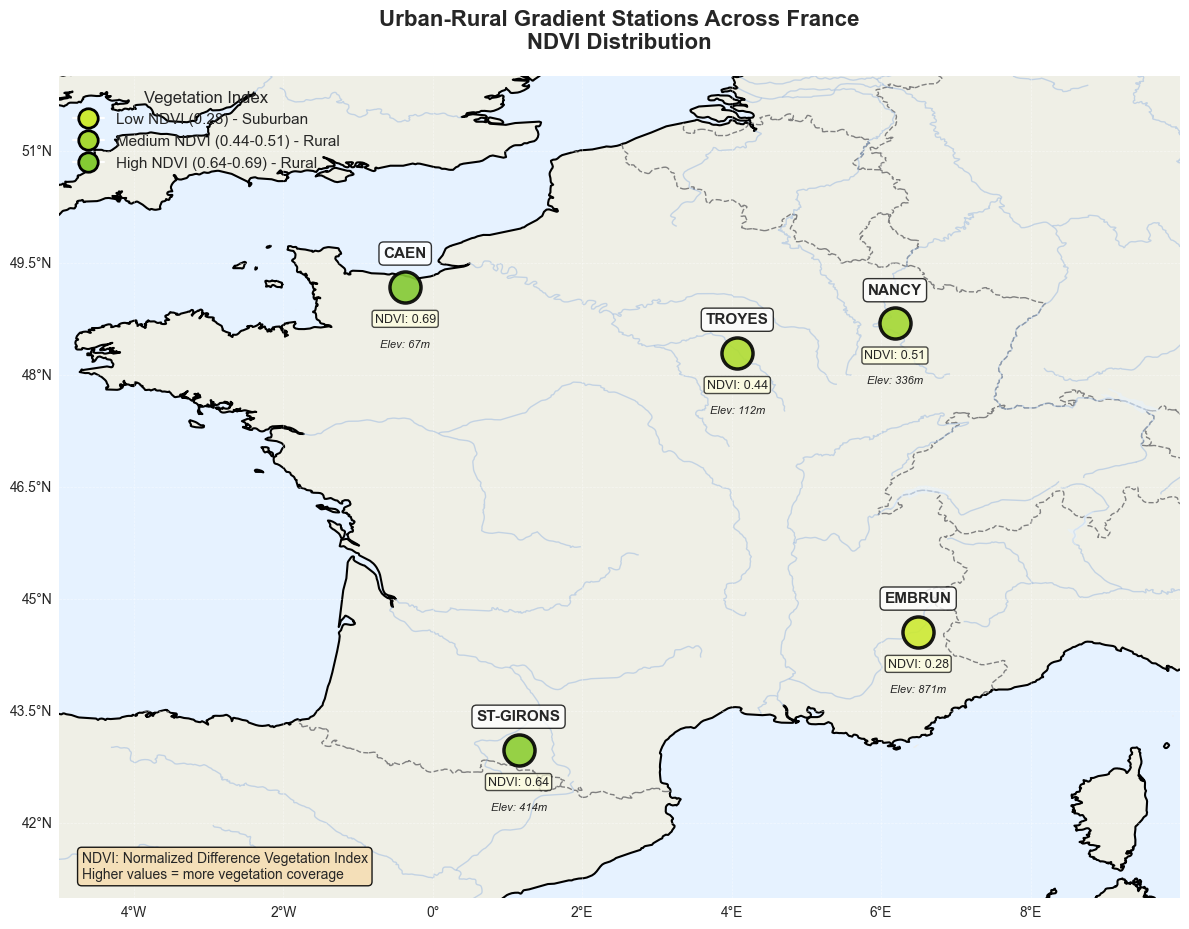


STATION SUMMARY - Urban-Rural Gradient Across France
Station         NDVI     Category     Elevation    Coordinates
------------------------------------------------------------
EMBRUN          0.28     Suburban      871m        (44.56°N, 6.50°E)
TROYES          0.44     Rural         112m        (48.30°N, 4.07°E)
NANCY           0.51     Rural         336m        (48.69°N, 6.18°E)
ST-GIRONS       0.64     Rural         414m        (42.98°N, 1.15°E)
CAEN            0.69     Rural          67m        (49.18°N, -0.37°E)


In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Station data with correct coordinates
stations = {
    'EMBRUN': {'lat': 44.5647, 'lon': 6.4958, 'ndvi': 0.28, 'category': 'Suburban', 'elevation': 871},
    'TROYES': {'lat': 48.2972, 'lon': 4.0744, 'ndvi': 0.44, 'category': 'Rural', 'elevation': 112},
    'NANCY': {'lat': 48.6921, 'lon': 6.1844, 'ndvi': 0.51, 'category': 'Rural', 'elevation': 336},
    'ST-GIRONS': {'lat': 42.9833, 'lon': 1.1467, 'ndvi': 0.64, 'category': 'Rural', 'elevation': 414},
    'CAEN': {'lat': 49.1829, 'lon': -0.3707, 'ndvi': 0.69, 'category': 'Rural', 'elevation': 67}
}

# Create figure with cartopy projection
fig = plt.figure(figsize=(12, 14))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to focus on France (west, east, south, north)
ax.set_extent([-5, 10, 41, 52], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f5f5dc', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='#e6f2ff')
ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
ax.add_feature(cfeature.BORDERS, linewidth=1, linestyle='--', edgecolor='gray')
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='#e6f2ff')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Color map for NDVI (green gradient)
def get_color(ndvi):
    # Lower NDVI = lighter green, Higher NDVI = darker green
    green_intensity = ndvi
    return (1 - green_intensity * 0.7, 1 - green_intensity * 0.3, 0.2)

# Plot stations
for name, data in stations.items():
    color = get_color(data['ndvi'])
    
    # Plot marker
    ax.scatter(data['lon'], data['lat'], s=500, c=[color], 
              edgecolors='black', linewidths=2.5, zorder=5, alpha=0.9,
              transform=ccrs.PlateCarree())
    
    # Add station name with background box for better visibility
    ax.text(data['lon'], data['lat'] + 0.35, name, 
           ha='center', va='bottom', fontsize=11, fontweight='bold', zorder=6,
           transform=ccrs.PlateCarree(),
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8))
    
    # Add NDVI value
    ax.text(data['lon'], data['lat'] - 0.35, f"NDVI: {data['ndvi']}", 
           ha='center', va='top', fontsize=9, zorder=6,
           transform=ccrs.PlateCarree(),
           bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', alpha=0.7))
    
    # Add elevation
    ax.text(data['lon'], data['lat'] - 0.70, f"Elev: {data['elevation']}m", 
           ha='center', va='top', fontsize=8, style='italic', zorder=6,
           transform=ccrs.PlateCarree())

# Set title
ax.set_title('Urban-Rural Gradient Stations Across France\nNDVI Distribution', 
            fontsize=16, fontweight='bold', pad=20)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=get_color(0.28), 
           markersize=14, label='Low NDVI (0.28) - Suburban', markeredgecolor='black', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=get_color(0.50), 
           markersize=14, label='Medium NDVI (0.44-0.51) - Rural', markeredgecolor='black', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=get_color(0.69), 
           markersize=14, label='High NDVI (0.64-0.69) - Rural', markeredgecolor='black', markeredgewidth=2)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.95,
         title='Vegetation Index', title_fontsize=12)

# Add info text
info_text = "NDVI: Normalized Difference Vegetation Index\nHigher values = more vegetation coverage"
ax.text(0.02, 0.02, info_text, transform=ax.transAxes, 
       fontsize=10, verticalalignment='bottom', 
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig('france_ndvi_stations_map.png', dpi=300, bbox_inches='tight')
plt.show()

# Print station summary
print("\n" + "="*60)
print("STATION SUMMARY - Urban-Rural Gradient Across France")
print("="*60)
print(f"{'Station':<15} {'NDVI':<8} {'Category':<12} {'Elevation':<12} {'Coordinates'}")
print("-"*60)
for name, data in sorted(stations.items(), key=lambda x: x[1]['ndvi']):
    coords = f"({data['lat']:.2f}°N, {data['lon']:.2f}°E)"
    print(f"{name:<15} {data['ndvi']:<8} {data['category']:<12} {data['elevation']:>4}m        {coords}")
print("="*60)